### Task 1

#### 2. Data Distillation Learning - MHIST
##### a) Train model with origianl dataset


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.amp import autocast, GradScaler

In [5]:
%pip install import-ipynb

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [6]:
import import_ipynb
from utils import get_network, get_time

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
# import os
# # os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'garbage_collection_threshold:0.6,max_split_size_mb:128'
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [12]:
train_folder = 'mhist_dataset/train'
test_folder = 'mhist_dataset/test'

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root=train_folder, transform=transform)
test_dataset = datasets.ImageFolder(root=test_folder, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers= 4, pin_memory=True)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [13]:
model = get_network(model='ConvNetD7', channel=1, num_classes=2, im_size=(224, 224))
model = model.to(device)
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = CosineAnnealingLR(optimizer, T_max=20)
criterion = torch.nn.CrossEntropyLoss()

In [8]:
def training_model(model, optimizer, scheduler, criterion, train_loader):
    torch.cuda.empty_cache()
    for epoch in range(20):
        model.train()

        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            labels = labels.long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            torch.cuda.empty_cache()
        scheduler.step()

        print(f"Epoch [{epoch+1}/20], Loss: {running_loss / len(train_loader.dataset)}")


In [14]:
training_model(model, optimizer, scheduler, criterion, train_loader)

Epoch [1/20], Loss: 0.5800561763226301
Epoch [2/20], Loss: 0.5275675971206577
Epoch [3/20], Loss: 0.4777392940685667
Epoch [4/20], Loss: 0.4251539101271794
Epoch [5/20], Loss: 0.36515385520869287
Epoch [6/20], Loss: 0.3390617588470722
Epoch [7/20], Loss: 0.2985866164476022
Epoch [8/20], Loss: 0.23788680054675573
Epoch [9/20], Loss: 0.16768076890501482
Epoch [10/20], Loss: 0.1214684370742447
Epoch [11/20], Loss: 0.06927432313047606
Epoch [12/20], Loss: 0.03647283720130893
Epoch [13/20], Loss: 0.01728700970438705
Epoch [14/20], Loss: 0.01046121015802197
Epoch [15/20], Loss: 0.007534441109960792
Epoch [16/20], Loss: 0.006359848806570316
Epoch [17/20], Loss: 0.005774518768249572
Epoch [18/20], Loss: 0.005447435968544806
Epoch [19/20], Loss: 0.005280822983718124
Epoch [20/20], Loss: 0.005204800208495266


In [15]:
model_path = 'models/mhist_original_grey.pth'
torch.save(model.state_dict(), model_path)

In [16]:
model_path = 'models/mhist_original_grey.pth'
model = get_network(model='ConvNetD7', channel=1, num_classes=2, im_size=(224, 224))
model.load_state_dict(torch.load(model_path))


<ipython-input-16-d0d1907d5a1f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [9]:
def evaluate_model(model, test_loader):
  model.to(device)
  model.eval()
  correct, total = 0, 0

  with torch.no_grad():
      for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          labels = labels.long()
          outputs = model(inputs)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  print(f'Test Accuracy: {accuracy:.2f}%')

In [19]:
evaluate_model(model, test_loader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Accuracy: 80.96%


In [20]:
%pip install ptflops

In [21]:
from ptflops import get_model_complexity_info

macs, params = get_model_complexity_info(model, (1, 224, 224), as_strings=True, print_per_layer_stat=True)
print(f"MACs: {macs}, Parameters: {params}")

ConvNet(
  888.83 k, 100.000% Params, 2.65 GMac, 99.336% MACs, 
  (features): Sequential(
    888.58 k, 99.971% Params, 2.65 GMac, 99.336% MACs, 
    (0): Conv2d(1.28 k, 0.144% Params, 66.54 MMac, 2.492% MACs, 1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
    (1): GroupNorm(256, 0.029% Params, 13.31 MMac, 0.498% MACs, 128, 128, eps=1e-05, affine=True)
    (2): ReLU(0, 0.000% Params, 6.65 MMac, 0.249% MACs, inplace=True)
    (3): AvgPool2d(0, 0.000% Params, 6.65 MMac, 0.249% MACs, kernel_size=2, stride=2, padding=0)
    (4): Conv2d(147.58 k, 16.604% Params, 1.92 GMac, 71.824% MACs, 128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): GroupNorm(256, 0.029% Params, 3.33 MMac, 0.125% MACs, 128, 128, eps=1e-05, affine=True)
    (6): ReLU(0, 0.000% Params, 1.66 MMac, 0.062% MACs, inplace=True)
    (7): AvgPool2d(0, 0.000% Params, 1.66 MMac, 0.062% MACs, kernel_size=2, stride=2, padding=0)
    (8): Conv2d(147.58 k, 16.604% Params, 479.5 MMac, 17.956% MACs, 128, 1

In [22]:
total_flops = 0

for inputs, labels in test_loader:
    total_flops += get_model_complexity_info(model, (1, 224, 224), as_strings=False)[0]

print(f"Total FLOPs for the test dataset: {total_flops}")

ConvNet(
  888.83 k, 100.000% Params, 2.65 GMac, 99.336% MACs, 
  (features): Sequential(
    888.58 k, 99.971% Params, 2.65 GMac, 99.336% MACs, 
    (0): Conv2d(1.28 k, 0.144% Params, 66.54 MMac, 2.492% MACs, 1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
    (1): GroupNorm(256, 0.029% Params, 13.31 MMac, 0.498% MACs, 128, 128, eps=1e-05, affine=True)
    (2): ReLU(0, 0.000% Params, 6.65 MMac, 0.249% MACs, inplace=True)
    (3): AvgPool2d(0, 0.000% Params, 6.65 MMac, 0.249% MACs, kernel_size=2, stride=2, padding=0)
    (4): Conv2d(147.58 k, 16.604% Params, 1.92 GMac, 71.824% MACs, 128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): GroupNorm(256, 0.029% Params, 3.33 MMac, 0.125% MACs, 128, 128, eps=1e-05, affine=True)
    (6): ReLU(0, 0.000% Params, 1.66 MMac, 0.062% MACs, inplace=True)
    (7): AvgPool2d(0, 0.000% Params, 1.66 MMac, 0.062% MACs, kernel_size=2, stride=2, padding=0)
    (8): Conv2d(147.58 k, 16.604% Params, 479.5 MMac, 17.956% MACs, 128, 1

##### b) Learn the synthetic dataset with attention matching algorithm

In [8]:
# step 4: real dataset loader
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

real_dataset = datasets.ImageFolder(root='mhist_dataset/train', transform=transform)
real_loader = torch.utils.data.DataLoader(real_dataset, batch_size=128, shuffle=True)


In [9]:
# set up the synthetic dataset
import random

num_classes = 2
num_images_per_class = 50
img_size = (1, 224, 224)

def generate_synthetic_dataset_with_noise(real_dataset, num_classes, images_per_class=50, noise_std=0.8):
    synthetic_images = []
    synthetic_labels = []

    for class_id in range(num_classes):
        # Randomly sample 50 images from each class
        indices = random.sample(
            [i for i, (_, label) in enumerate(real_dataset) if label == class_id],
            images_per_class
        )

        for i in indices:
            img_real = real_dataset[i][0].to(device)
            # noise = torch.rand(size=img_real.shape, requires_grad=True, device=device)
            noise = torch.normal(mean=0, std=noise_std, size=img_real.shape, requires_grad=True, device=device)
            noise = noise.to(img_real.device)

            synthetic_image = img_real + noise

            synthetic_image = torch.clamp(synthetic_image, 0, 1)

            synthetic_images.append(synthetic_image)
            synthetic_labels.append(real_dataset[i][1])

    img_syn = torch.stack(synthetic_images)
    labels_syn = torch.tensor(synthetic_labels, device=device)

    return img_syn, labels_syn

In [10]:
#step 2: optimizer
img_syn, labels_syn = generate_synthetic_dataset_with_noise(real_dataset, num_classes)

img_syn = torch.nn.Parameter(img_syn)
optimizer_img = optim.SGD([img_syn], lr=0.1)  # lr is eta_s

In [11]:
# step 3: set up model - ConvNET - 7 in this case
# freeze the model's weights so that only the synthetic dataset is updated

model_path = 'models/mhist_original_grey.pth'
net = get_network(model='ConvNetD7', channel=1, num_classes=2, im_size=(224, 224))
net.load_state_dict(torch.load(model_path, map_location=device))
net.to(device)
net.train()

for param in list(net.parameters()):
    param.requires_grad = False

<ipython-input-11-da54f3140c0f>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(model_path, map_location=device))


In [12]:
# step 5: hook
# Using hook to extract the activations from the layers (attention maps) to compare the attention maps from real to synthetic
activations = {}

def get_activation(name):
    def hook_func(m, inp, op):
        activations[name] = op.detach()

    return hook_func


''' Defining the Refresh Function to store Activations and reset Collection '''


def refresh_activations(activations):
    model_set_activations = []  # Jagged Tensor Creation
    for i in activations.keys():
        model_set_activations.append(activations[i])
    activations = {}
    return activations, model_set_activations


def delete_hooks(hooks):
    for i in hooks:
        i.remove()
    return


def attach_hooks(net):
    hooks = []
    for name, module in net.named_modules():
        if isinstance(module, nn.ReLU):
            hooks.append(module.register_forward_hook(get_activation(name)))
    return hooks

In [13]:
# step 6: Attention Matching Map
def get_attention(feature_set, param=0, exp=4, norm='l2'):
    if param==0:
        attention_map = torch.sum(torch.abs(feature_set), dim=1)

    elif param ==1:
        attention_map =  torch.sum(torch.abs(feature_set)**exp, dim=1)

    elif param == 2:
        attention_map =  torch.max(torch.abs(feature_set)**exp, dim=1)

    if norm == 'l2':
        # Dimension: [B x (H*W)] -- Vectorized
        vectorized_attention_map =  attention_map.view(feature_set.size(0), -1)
        normalized_attention_maps = F.normalize(vectorized_attention_map, p=2, dim=1)

    return normalized_attention_maps

In [14]:
# step 7: error function
def error(real, syn, err_type="MSE"):
    if err_type == "MSE":
        err = torch.sum((torch.mean(real, dim=0) - torch.mean(syn, dim=0)) ** 2)
    elif err_type == "MAE":
        err = torch.sum(torch.abs(torch.mean(real, dim=0) - torch.mean(syn, dim=0)))
    elif err_type == "MSE_B":
        err = torch.sum(
            (torch.mean(real.reshape(2, -1).cpu(), dim=1) - torch.mean(syn.reshape(2, -1).cpu(), dim=1)) ** 2)
    else:
        raise ValueError("Invalid error type")
    return err

In [15]:
# step 8: training loop
def train_dataset(img_syn, labels_syn, activations={}):
    num_iterations = 200
    learning_rate_model = 0.01


    losses = []
    for iteration in range(num_iterations):
        print(f"Iteration {iteration + 1}/{num_iterations}")

        images_syn_all = []
        labels_syn_all = []
        images_real_all = []
        labels_real_all = []

        for c in range(num_classes):
            img_real, label_real = next(iter(real_loader))
            img_real = img_real.to(device)
            img_syn_per_class = img_syn[c * num_images_per_class:(c + 1) * num_images_per_class].to(device)
            label_syn_per_class = labels_syn[c * num_images_per_class:(c + 1) * num_images_per_class]

            images_real_all.append(img_real)
            labels_real_all.append(label_real)
            images_syn_all.append(img_syn_per_class)
            labels_syn_all.append(label_syn_per_class)

        images_real_all = torch.cat(images_real_all, dim=0)
        labels_real_all = torch.cat(labels_real_all, dim=0)
        images_syn_all = torch.cat(images_syn_all, dim=0)
        labels_syn_all = torch.cat(labels_syn_all, dim=0)

        net.train()
        hooks = attach_hooks(net)

        output_real = net(images_real_all)[0]
        activations, original_model_set_activations = refresh_activations(activations)

        output_syn = net(images_syn_all)[0]
        activations, syn_model_set_activations = refresh_activations(activations)
        delete_hooks(hooks)

        length_of_network = len(original_model_set_activations)

        loss = torch.tensor(0.0)
        mid_loss = 0
        out_loss = 0
        loss_avg = 0

        for layer in range(length_of_network - 1):
            real_attention = get_attention(original_model_set_activations[layer], param=1, exp=1, norm='l2')
            syn_attention = get_attention(syn_model_set_activations[layer], param=1, exp=1, norm='l2')

            tl = 100 * error(real_attention, syn_attention, err_type="MSE_B")
            loss += tl
            mid_loss += tl.item()

        output_loss = 100 * 0.01 * error(output_real, output_syn, err_type="MSE_B")
        loss += output_loss
        out_loss += output_loss.item()

        optimizer_img.zero_grad()
        loss.backward()
        optimizer_img.step()
        loss_avg += loss.item()
        torch.cuda.empty_cache()

        loss_avg /= (num_classes)
        out_loss /= (num_classes)
        mid_loss /= (num_classes)
        losses.append((loss_avg, out_loss, mid_loss))
        if iteration % 10 == 0:
            print('%s iter = %05d, loss = %.4f' % (get_time(), iteration, loss_avg))

    print("training completed.")
    return img_syn, labels_syn, losses


In [16]:
def save_results(img_syn, labels_syn, losses, noise_type):
    save_path = f"mhist_result/{noise_type}_synthetic_dataset_grey.pt"

    torch.save({'images': img_syn, 'labels': labels_syn}, save_path)

    print(f"Synthetic dataset saved to {save_path}")

    loss_log_path = f"mhist_result/{noise_type}_training_losses_grey.txt"
    with open(loss_log_path, "w") as f:
        for epoch, loss in enumerate(losses):
            f.write(f"Iteration {epoch}: Loss = {loss}\n")

    print(f"Training losses saved to {loss_log_path}")


In [45]:
img_syn, labels_syn, losses = train_dataset(img_syn, labels_syn)
save_results(img_syn, labels_syn, losses, 'Random')

Iteration 1/200
[2024-10-24 04:52:36] iter = 00000, loss = 10.7898
Iteration 2/200
Iteration 3/200
Iteration 4/200
Iteration 5/200
Iteration 6/200
Iteration 7/200
Iteration 8/200
Iteration 9/200
Iteration 10/200
Iteration 11/200
[2024-10-24 04:55:55] iter = 00010, loss = 1.9954
Iteration 12/200
Iteration 13/200
Iteration 14/200
Iteration 15/200
Iteration 16/200
Iteration 17/200
Iteration 18/200
Iteration 19/200
Iteration 20/200
Iteration 21/200
[2024-10-24 04:59:18] iter = 00020, loss = 7.8242
Iteration 22/200
Iteration 23/200
Iteration 24/200
Iteration 25/200
Iteration 26/200
Iteration 27/200
Iteration 28/200
Iteration 29/200
Iteration 30/200
Iteration 31/200
[2024-10-24 05:02:39] iter = 00030, loss = 8.4750
Iteration 32/200
Iteration 33/200
Iteration 34/200
Iteration 35/200
Iteration 36/200
Iteration 37/200
Iteration 38/200
Iteration 39/200
Iteration 40/200
Iteration 41/200
[2024-10-24 05:06:00] iter = 00040, loss = 0.9198
Iteration 42/200
Iteration 43/200
Iteration 44/200
Iteration 

In [17]:
img_syn, labels_syn, losses = train_dataset(img_syn, labels_syn)
save_results(img_syn, labels_syn, losses, 'Gaussian')

Iteration 1/200
[2024-10-24 20:26:57] iter = 00000, loss = 2.4032
Iteration 2/200
Iteration 3/200
Iteration 4/200
Iteration 5/200
Iteration 6/200
Iteration 7/200
Iteration 8/200
Iteration 9/200
Iteration 10/200
Iteration 11/200
[2024-10-24 20:32:03] iter = 00010, loss = 0.4067
Iteration 12/200
Iteration 13/200
Iteration 14/200
Iteration 15/200
Iteration 16/200
Iteration 17/200
Iteration 18/200
Iteration 19/200
Iteration 20/200
Iteration 21/200
[2024-10-24 20:37:10] iter = 00020, loss = 1.4316
Iteration 22/200
Iteration 23/200
Iteration 24/200
Iteration 25/200
Iteration 26/200
Iteration 27/200
Iteration 28/200
Iteration 29/200
Iteration 30/200
Iteration 31/200
[2024-10-24 20:42:19] iter = 00030, loss = 16.2472
Iteration 32/200
Iteration 33/200
Iteration 34/200
Iteration 35/200
Iteration 36/200
Iteration 37/200
Iteration 38/200
Iteration 39/200
Iteration 40/200
Iteration 41/200
[2024-10-24 20:47:26] iter = 00040, loss = 3.9118
Iteration 42/200
Iteration 43/200
Iteration 44/200
Iteration 

##### 2c) Visualize the condensed images per class

In [22]:
import torch
import os
import matplotlib.pyplot as plt

def display_image_grid(img_syn, labels_syn, noise_type):
    # Create directory to save grid images
    save_dir = f"mhist_result/{noise_type}_grid_grey"
    os.makedirs(save_dir, exist_ok=True)

    num_samples_per_class = 50

    class_dict = {}

    for img, label in zip(img_syn, labels_syn):
        label = label.item()
        if label not in class_dict:
            class_dict[label] = []
        class_dict[label].append(img)

    for class_label, images in class_dict.items():
        selected_images = images[:num_samples_per_class]

        fig, axs = plt.subplots(5, 10, figsize=(15, 7))
        fig.suptitle(f"Class {class_label} - {noise_type}", fontsize=16)
        fig.patch.set_facecolor('white')

        # Display each image
        for idx, img in enumerate(selected_images):
            img_np = img.squeeze(0).detach().numpy()  # For grayscale, remove channel dimension
            axs[idx // 10, idx % 10].imshow(img_np, cmap='gray')  # Use 'gray' colormap
            axs[idx // 10, idx % 10].axis('off')
            axs[idx // 10, idx % 10].set_facecolor('white')


        plt.show()

        # Save the grid of images as a single image file for the report
        grid_save_path = os.path.join(save_dir, f"class_{class_label}_grid.png")
        fig.savefig(grid_save_path, facecolor='white')  # Save grid with white background
        plt.close()

    print(f"Image grids saved to {save_dir}")

<ipython-input-23-e770da397fb2>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_syn_loaded = torch.load('mhist_result/Random_synthetic_dataset_grey.pt')


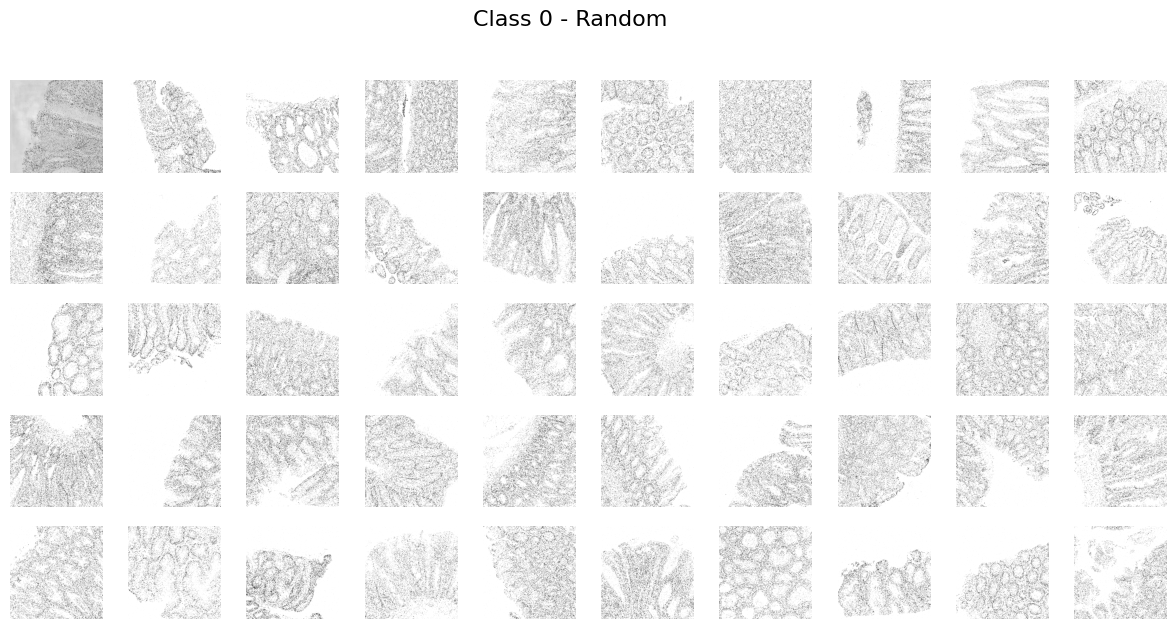

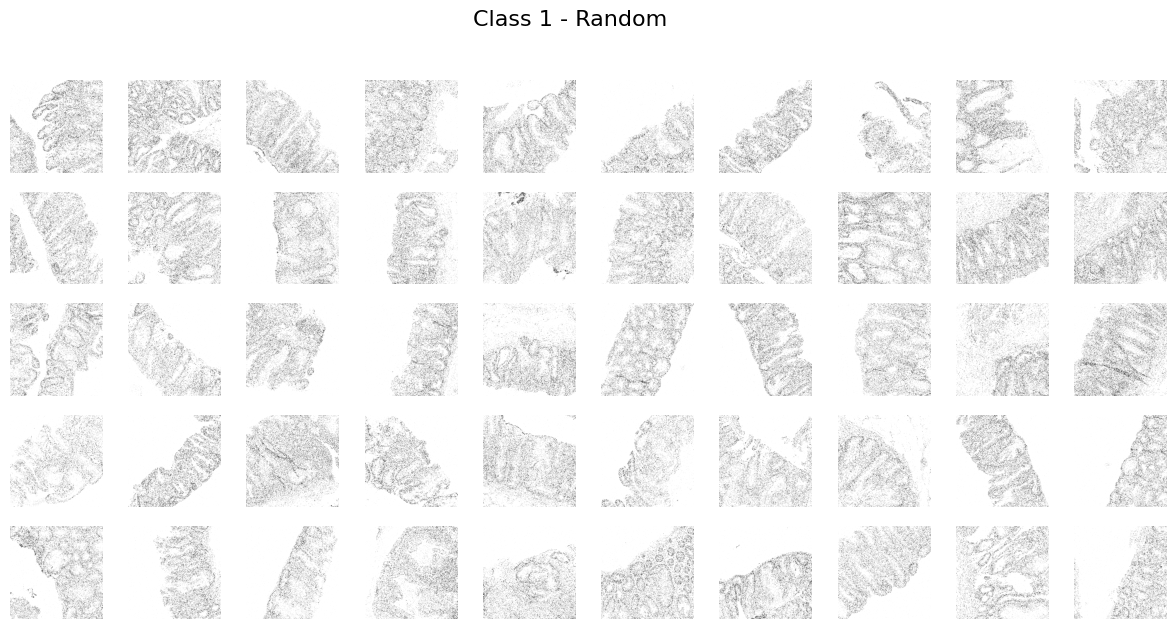

Image grids saved to mhist_result/Random_grid_grey


In [23]:
img_syn_loaded = torch.load('mhist_result/Random_synthetic_dataset_grey.pt')
img_syn = img_syn_loaded['images']
labels_syn = img_syn_loaded['labels']

display_image_grid(img_syn, labels_syn, noise_type='Random')

<ipython-input-24-53bdb212959b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_syn_loaded = torch.load('mhist_result/Gaussian_synthetic_dataset_grey.pt')


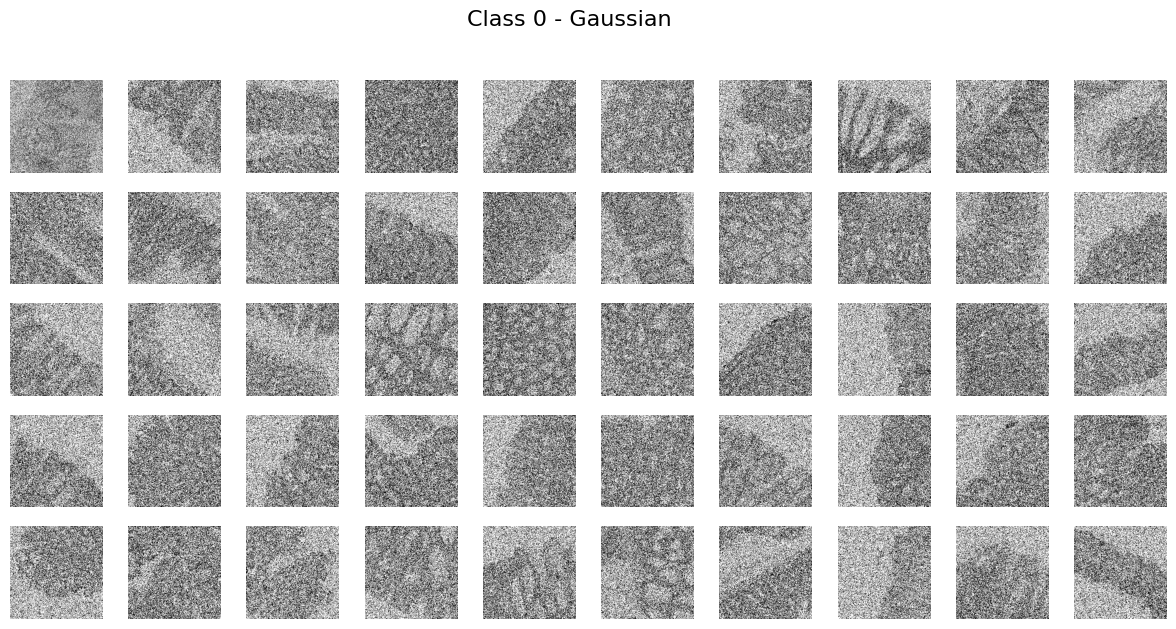

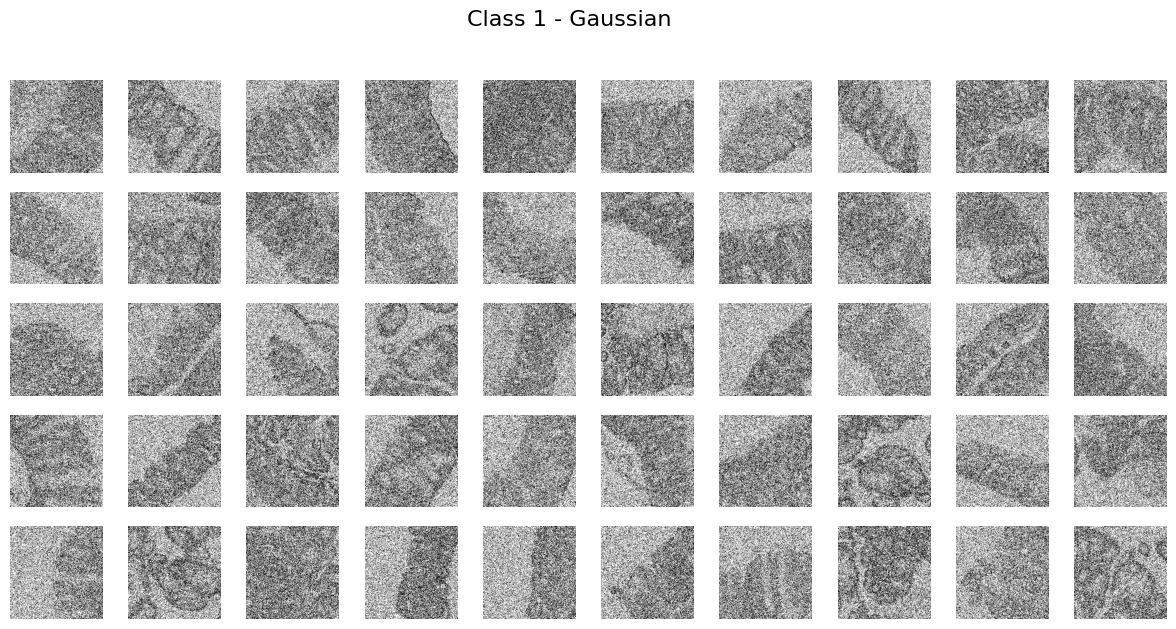

Image grids saved to mhist_result/Gaussian_grid_grey


In [24]:
img_syn_loaded = torch.load('mhist_result/Gaussian_synthetic_dataset_grey.pt')
img_syn = img_syn_loaded['images']
labels_syn = img_syn_loaded['labels']

display_image_grid(img_syn, labels_syn, noise_type='Gaussian')

##### 2e) Train the model with condensed dataset

In [25]:
train_folder = 'mhist_dataset/train'

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root=train_folder, transform=transform)


def get_subset_per_class(dataset, num_samples_per_class, num_classes):
    from torch.utils.data import Subset
    class_indices = {class_idx: [] for class_idx in range(num_classes)}

    for idx, (_, label) in enumerate(dataset):
        if len(class_indices[label]) < num_samples_per_class:
            class_indices[label].append(idx)

    selected_indices = []
    for indices in class_indices.values():
        selected_indices.extend(indices)

    return Subset(dataset, selected_indices)

num_classes = 2
num_samples_per_class = 50
train_subset = get_subset_per_class(train_dataset, num_samples_per_class, num_classes)

train_loader_subset = DataLoader(train_subset, batch_size=32, shuffle=True)

class_count = {0: 0, 1: 0}
for imgs, labels in train_loader_subset:
    for label in labels:
        class_count[label.item()] += 1

print(f"Class distribution in subset: {class_count}")



Class distribution in subset: {0: 50, 1: 50}


In [27]:
model_100 = get_network(model='ConvNetD7', channel=1, num_classes=2, im_size=(224, 224))
optimizer = SGD(model_100.parameters(), lr=0.01, momentum=0.9)
scheduler = CosineAnnealingLR(optimizer, T_max=20)
criterion = torch.nn.CrossEntropyLoss()

training_model(model_100, optimizer, scheduler,
               criterion, train_loader_subset)

Epoch [1/20], Loss: 0.6800658893585205
Epoch [2/20], Loss: 0.6276747035980225
Epoch [3/20], Loss: 0.6193497848510742
Epoch [4/20], Loss: 0.5472510766983032
Epoch [5/20], Loss: 0.5216139769554138
Epoch [6/20], Loss: 0.4955581283569336
Epoch [7/20], Loss: 0.48030255079269407
Epoch [8/20], Loss: 0.39853052198886874
Epoch [9/20], Loss: 0.33602761149406435
Epoch [10/20], Loss: 0.2825913667678833
Epoch [11/20], Loss: 0.24810590505599975
Epoch [12/20], Loss: 0.19006028294563293
Epoch [13/20], Loss: 0.17215485006570816
Epoch [14/20], Loss: 0.13774674534797668
Epoch [15/20], Loss: 0.11250058650970458
Epoch [16/20], Loss: 0.10368990868330002
Epoch [17/20], Loss: 0.10392761662602425
Epoch [18/20], Loss: 0.09392672061920165
Epoch [19/20], Loss: 0.08700235098600388
Epoch [20/20], Loss: 0.0838085275888443


In [10]:
random_model = get_network(model='ConvNetD7', channel=1, num_classes=2, im_size=(224, 224))
random_optimizer = SGD(random_model.parameters(), lr=0.01, momentum=0.9)

gaussian_model = get_network(model='ConvNetD7', channel=1, num_classes=2, im_size=(224, 224))
gaussian_optimizer = SGD(gaussian_model.parameters(), lr=0.01, momentum=0.9)

random_scheduler = CosineAnnealingLR(random_optimizer, T_max=20)
gaussian_scheduler = CosineAnnealingLR(gaussian_optimizer, T_max=20)

criterion = torch.nn.CrossEntropyLoss()

In [11]:
from torch.utils.data import TensorDataset, DataLoader

img_syn_loaded = torch.load('mhist_result/Random_synthetic_dataset_grey.pt')
img_syn = img_syn_loaded['images']
labels_syn = img_syn_loaded['labels']

random_synthetic_dataset = TensorDataset(img_syn, labels_syn)

random_train_loader = DataLoader(random_synthetic_dataset, batch_size=32, shuffle=True)

training_model(random_model, random_optimizer, random_scheduler,
               criterion, random_train_loader)

<ipython-input-11-165024491039>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_syn_loaded = torch.load('mhist_result/Random_synthetic_dataset_grey.pt')


Epoch [1/20], Loss: 0.7344422912597657
Epoch [2/20], Loss: 0.6520115089416504
Epoch [3/20], Loss: 0.6542135667800903
Epoch [4/20], Loss: 0.5990556168556214
Epoch [5/20], Loss: 0.6569379949569703
Epoch [6/20], Loss: 0.6183186221122742
Epoch [7/20], Loss: 0.5902884769439697
Epoch [8/20], Loss: 0.5144532871246338
Epoch [9/20], Loss: 0.4805491292476654
Epoch [10/20], Loss: 0.4288655972480774
Epoch [11/20], Loss: 0.3973651570081711
Epoch [12/20], Loss: 0.3572183322906494
Epoch [13/20], Loss: 0.32145068049430847
Epoch [14/20], Loss: 0.3036400234699249
Epoch [15/20], Loss: 0.26015922546386716
Epoch [16/20], Loss: 0.2523903656005859
Epoch [17/20], Loss: 0.23391836047172546
Epoch [18/20], Loss: 0.2276192969083786
Epoch [19/20], Loss: 0.21900270104408265
Epoch [20/20], Loss: 0.21200921833515168


In [13]:
img_syn_loaded = torch.load('mhist_result/Gaussian_synthetic_dataset_grey.pt')
img_syn = img_syn_loaded['images']
labels_syn = img_syn_loaded['labels']

gaussian_synthetic_dataset = TensorDataset(img_syn, labels_syn)

gaussian_train_loader = DataLoader(gaussian_synthetic_dataset, batch_size=32, shuffle=True)

training_model(gaussian_model, gaussian_optimizer, gaussian_scheduler,
               criterion, gaussian_train_loader)

<ipython-input-13-cce7a4d9836c>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_syn_loaded = torch.load('mhist_result/Gaussian_synthetic_dataset_grey.pt')


Epoch [1/20], Loss: 0.6906321501731872
Epoch [2/20], Loss: 0.7506483197212219
Epoch [3/20], Loss: 0.6127559423446656
Epoch [4/20], Loss: 0.6095644092559814
Epoch [5/20], Loss: 0.5661391663551331
Epoch [6/20], Loss: 0.5331894397735596
Epoch [7/20], Loss: 0.46638983249664306
Epoch [8/20], Loss: 0.4130558514595032
Epoch [9/20], Loss: 0.39071473479270935
Epoch [10/20], Loss: 0.3420375382900238
Epoch [11/20], Loss: 0.29778088748455045
Epoch [12/20], Loss: 0.2540138041973114
Epoch [13/20], Loss: 0.21688198208808898
Epoch [14/20], Loss: 0.17133938670158386
Epoch [15/20], Loss: 0.16198123037815093
Epoch [16/20], Loss: 0.12755277007818222
Epoch [17/20], Loss: 0.10797728538513184
Epoch [18/20], Loss: 0.09612441897392272
Epoch [19/20], Loss: 0.09031598627567292
Epoch [20/20], Loss: 0.08734405010938645


In [14]:
test_folder = 'mhist_dataset/test'

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

test_dataset = datasets.ImageFolder(root=test_folder, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [33]:
evaluate_model(model_100, test_loader)

Test Accuracy: 61.00%


In [15]:
evaluate_model(random_model, test_loader)

Test Accuracy: 49.23%


In [16]:
evaluate_model(gaussian_model, test_loader)

Test Accuracy: 59.37%


In [31]:
%pip install ptflops

#### 3 Cross-Architecture Generalization

In [47]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, norm='instancenorm'):
        super(BasicBlock, self).__init__()
        self.norm = norm
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(self.expansion*planes, self.expansion*planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, channel=3, num_classes=10, norm='instancenorm'):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.norm = norm

        self.conv1 = nn.Conv2d(channel, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.GroupNorm(64, 64, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.classifier = nn.Linear(512 * 7 * 7, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.norm))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def embed(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        return out

def ResNet18(channel, num_classes):
    return ResNet(BasicBlock, [2,2,2,2], channel=channel, num_classes=num_classes)

In [48]:
resnet_100 = ResNet18(channel=1, num_classes=2)
resnet_100.to(device)

optimizer = SGD(resnet_100.parameters(), lr=0.01, momentum=0.9)
scheduler = CosineAnnealingLR(optimizer, T_max=20)
criterion = torch.nn.CrossEntropyLoss()

training_model(resnet_100, optimizer, scheduler,
               criterion, train_loader_subset)

Epoch [1/20], Loss: 15.676922035217284
Epoch [2/20], Loss: 33.10848127365112
Epoch [3/20], Loss: 11.847649810314179
Epoch [4/20], Loss: 22.499607620239257
Epoch [5/20], Loss: 23.28870838165283
Epoch [6/20], Loss: 17.890923442840577
Epoch [7/20], Loss: 19.749382934570313
Epoch [8/20], Loss: 6.358026123046875
Epoch [9/20], Loss: 4.225709037780762
Epoch [10/20], Loss: 3.152871150970459
Epoch [11/20], Loss: 3.109430236816406
Epoch [12/20], Loss: 2.2011211013793943
Epoch [13/20], Loss: 1.0257111915573478
Epoch [14/20], Loss: 1.2483240288496018
Epoch [15/20], Loss: 0.8679514563083649
Epoch [16/20], Loss: 0.5616651006042958
Epoch [17/20], Loss: 0.4505112934112549
Epoch [18/20], Loss: 0.2544243764877319
Epoch [19/20], Loss: 0.3400416199862957
Epoch [20/20], Loss: 0.3566016912460327


In [49]:
random_resnet = ResNet18(channel=1, num_classes=2)
random_optimizer = SGD(random_resnet.parameters(), lr=0.01, momentum=0.9)
random_resnet.to(device)

gaussian_resnet = ResNet18(channel=1, num_classes=2)
gaussian_optimizer = SGD(gaussian_resnet.parameters(), lr=0.01, momentum=0.9)
gaussian_resnet.to(device)

random_scheduler = CosineAnnealingLR(random_optimizer, T_max=20)
gaussian_scheduler = CosineAnnealingLR(gaussian_optimizer, T_max=20)

criterion = torch.nn.CrossEntropyLoss()

In [50]:
img_syn_loaded = torch.load('mhist_result/Random_synthetic_dataset_grey.pt')
img_syn = img_syn_loaded['images']
labels_syn = img_syn_loaded['labels']

random_synthetic_dataset = TensorDataset(img_syn, labels_syn)

random_train_loader = DataLoader(random_synthetic_dataset, batch_size=32, shuffle=True)

training_model(random_resnet, random_optimizer, random_scheduler,
               criterion, random_train_loader)

<ipython-input-50-13d17fd31a95>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_syn_loaded = torch.load('mhist_result/Random_synthetic_dataset_grey.pt')


Epoch [1/20], Loss: 15.64375057220459
Epoch [2/20], Loss: 21.960468063354494
Epoch [3/20], Loss: 28.89935287475586
Epoch [4/20], Loss: 8.655755580661825
Epoch [5/20], Loss: 5.875408477783203
Epoch [6/20], Loss: 5.556482925415039
Epoch [7/20], Loss: 9.00872426666785
Epoch [8/20], Loss: 9.126153428554534
Epoch [9/20], Loss: 4.18918820373714
Epoch [10/20], Loss: 2.4496970748901368
Epoch [11/20], Loss: 1.673740978240967
Epoch [12/20], Loss: 1.1612120489776134
Epoch [13/20], Loss: 0.8174842834472656
Epoch [14/20], Loss: 0.572810349156207
Epoch [15/20], Loss: 0.4735237121582031
Epoch [16/20], Loss: 0.5390723943710327
Epoch [17/20], Loss: 0.32579860684927553
Epoch [18/20], Loss: 0.3289111599326134
Epoch [19/20], Loss: 0.33634919337928293
Epoch [20/20], Loss: 0.32238091664854435


In [51]:
img_syn_loaded = torch.load('mhist_result/Gaussian_synthetic_dataset_grey.pt')
img_syn = img_syn_loaded['images']
labels_syn = img_syn_loaded['labels']

gaussian_synthetic_dataset = TensorDataset(img_syn, labels_syn)

gaussian_train_loader = DataLoader(gaussian_synthetic_dataset, batch_size=32, shuffle=True)

training_model(gaussian_resnet, gaussian_optimizer, gaussian_scheduler,
               criterion, gaussian_train_loader)

<ipython-input-51-100f4192e8d5>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_syn_loaded = torch.load('mhist_result/Gaussian_synthetic_dataset_grey.pt')


Epoch [1/20], Loss: 18.045748348236085
Epoch [2/20], Loss: 13.57212776184082
Epoch [3/20], Loss: 53.92369262695313
Epoch [4/20], Loss: 32.7806999206543
Epoch [5/20], Loss: 19.860058097839357
Epoch [6/20], Loss: 9.86440523147583
Epoch [7/20], Loss: 6.179166069030762
Epoch [8/20], Loss: 4.693675270080567
Epoch [9/20], Loss: 4.260248184204102
Epoch [10/20], Loss: 2.671837387084961
Epoch [11/20], Loss: 2.064366798400879
Epoch [12/20], Loss: 1.5709011193737388
Epoch [13/20], Loss: 1.1560060024261474
Epoch [14/20], Loss: 0.8099405437707901
Epoch [15/20], Loss: 0.7898124885559082
Epoch [16/20], Loss: 0.563833475112915
Epoch [17/20], Loss: 0.4191379161551595
Epoch [18/20], Loss: 0.34240916699171065
Epoch [19/20], Loss: 0.31296534776687623
Epoch [20/20], Loss: 0.3022551711648703


In [52]:
evaluate_model(resnet_100, test_loader)

Test Accuracy: 53.63%


In [53]:
evaluate_model(random_resnet, test_loader)


Test Accuracy: 51.28%


In [54]:
evaluate_model(gaussian_resnet, test_loader)


Test Accuracy: 55.78%


In [55]:
from ptflops import get_model_complexity_info
total_flops = 0

for inputs, labels in test_loader:
    total_flops += get_model_complexity_info(resnet_100, (1, 224, 224), as_strings=False)[0]

print(f"Total FLOPs for the test dataset: {total_flops}")

ResNet(
  11.22 M, 100.000% Params, 27.22 GMac, 99.898% MACs, 
  (conv1): Conv2d(576, 0.005% Params, 28.9 MMac, 0.106% MACs, 1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): GroupNorm(128, 0.001% Params, 6.42 MMac, 0.024% MACs, 64, 64, eps=1e-05, affine=True)
  (layer1): Sequential(
    147.97 k, 1.319% Params, 7.42 GMac, 27.250% MACs, 
    (0): BasicBlock(
      73.98 k, 0.660% Params, 3.71 GMac, 13.625% MACs, 
      (conv1): Conv2d(36.86 k, 0.329% Params, 1.85 GMac, 6.789% MACs, 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): GroupNorm(128, 0.001% Params, 6.42 MMac, 0.024% MACs, 64, 64, eps=1e-05, affine=True)
      (conv2): Conv2d(36.86 k, 0.329% Params, 1.85 GMac, 6.789% MACs, 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): GroupNorm(128, 0.001% Params, 6.42 MMac, 0.024% MACs, 64, 64, eps=1e-05, affine=True)
      (shortcut): Sequential(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
   